# COVID-19 Detection - Xception Model

### Import the required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import keras
from keras import optimizers, callbacks
from keras.layers import Flatten, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import Xception
from keras.optimizers import Adam
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import zipfile
import warnings
warnings.filterwarnings("ignore")

### Download and unzip the dataset

In [2]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

Dataset URL: https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset
License(s): CC-BY-NC-SA-4.0
100% 230M/230M [00:11<00:00, 24.6MB/s]
100% 230M/230M [00:11<00:00, 21.6MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/sarscov2-ctscan-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

### Load the dataset

In [4]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content'
train_dir = os.path.join(data_dir)

In [5]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE = 64
N_ch = 3
IMAGE_SIZE = 64

### Split the dataset into train and test sets

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [7]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

2481it [00:10, 245.78it/s]


(2481, 64, 64, 3)


In [9]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

### Model architecutre

In [11]:
def build_Xception():
    xception = Xception(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = xception(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(2, activation='softmax', name='root')(x)

    model = Model(input, output)

    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [12]:
model = build_Xception()

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('xception_model.keras', verbose=1, save_best_only=True, monitor='val_loss', mode='min')

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 3)           │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2, 2, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,395,838 (81.62 MB)

 Trainable params: 21,336,702 (81.39 MB)

 Non-trainable params: 59,136 (231.00 KB)

### Model training

In [13]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[annealer, checkpoint],
    validation_data=(X_test, Y_test)
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5172 - loss: 1.1360
Epoch 1: val_loss improved from inf to 5.94952, saving model to xception_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 66s 399ms/step - accuracy: 0.5173 - loss: 1.1334 - val_accuracy: 0.5191 - val_loss: 5.9495 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss did not improve from 5.94952
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5191 - val_loss: 5.9495 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5943 - loss: 0.8310
Epoch 3: val_loss improved from 5.94952 to 1.01484, saving model to xception_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.5943 - loss: 0.8301 - val_accuracy: 0.5755 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss did not improve from 1.01484
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5755

### Model evaluation

In [14]:
model.load_weights("xception_model.keras")
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9885 - loss: 0.0707
Test Loss: 0.04131205379962921
Test accuracy: 0.9879275560379028


In [15]:
Y_pred = np.argmax(model.predict(X_test), axis=-1)
Y_test_labels = np.argmax(Y_test, axis=-1)
print(classification_report(Y_test_labels, Y_pred, target_names=['COVID', 'non-COVID']))

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step
              precision    recall  f1-score   support

       COVID       0.98      0.99      0.99       239
   non-COVID       0.99      0.98      0.99       258

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


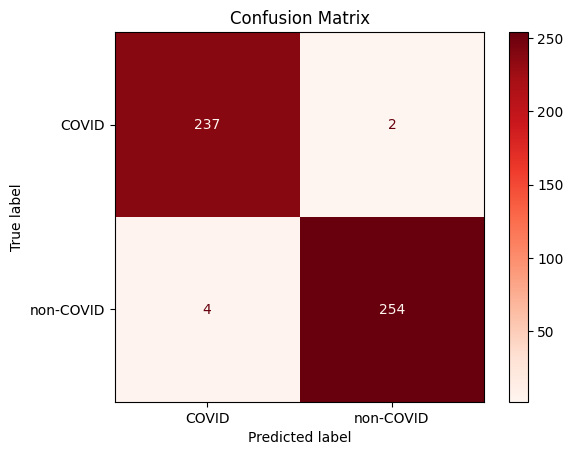

In [16]:
Y_pred = model.predict(X_test)
Y_predx = np.argmax(Y_pred, axis=-1)
Y_testx = np.argmax(Y_test, axis=-1)
cf_matrix = confusion_matrix(Y_testx, Y_predx)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['COVID', 'non-COVID'])
disp.plot(cmap='Reds')
plt.title("Confusion Matrix")
plt.show()

### Visualizing accuracy and loss over epochs

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

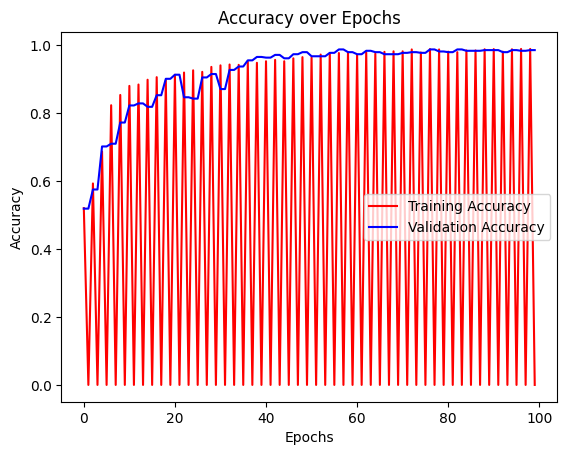

In [18]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

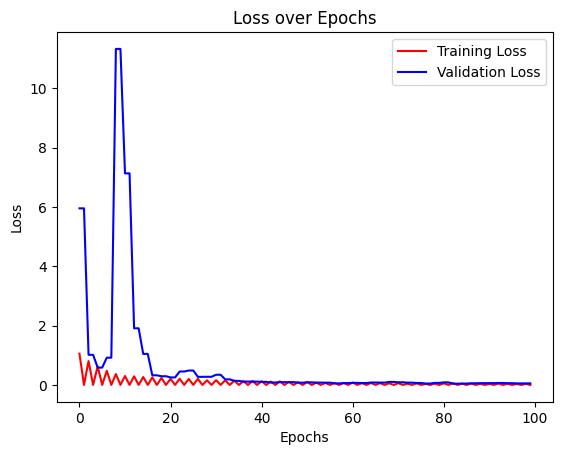

In [19]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Model prediction

In [20]:
def predict_image(image_path, model, target_size=(64, 64), display_size=(256, 256)):

    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)

    disease_types = ['COVID', 'non-COVID']
    predicted_disease = disease_types[predicted_class[0]]
    confidence = np.max(prediction)

    img_original = cv2.imread(image_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_original, display_size, interpolation=cv2.INTER_LINEAR)

    plt.imshow(img_resized)
    plt.title(f"Predicted Disease: {predicted_disease}\nConfidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()

    return predicted_disease, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


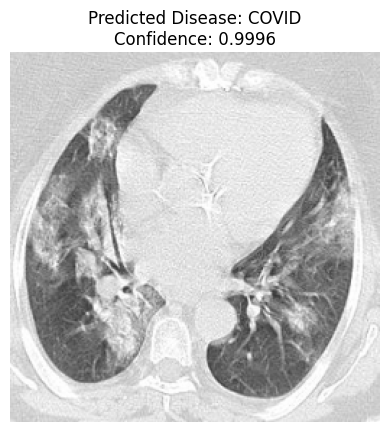

In [21]:
image_path = '/content/COVID/Covid (1007).png'
disease, confidence = predict_image(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


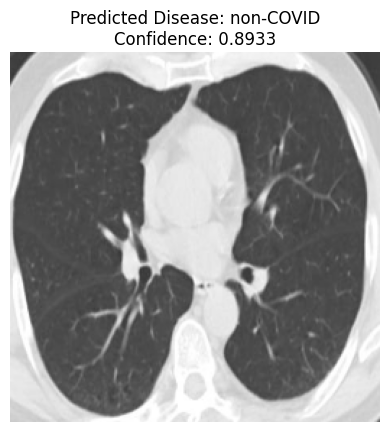

In [22]:
image_path = '/content/non-COVID/Non-Covid (1007).png'
disease, confidence = predict_image(image_path, model)